### This notebook contains my experiments with time-frequency analysis, primarily based on the exercises from the book Analyzing Neural Time Series by Mike X. Cohen. I discovored time-frequency analysis using morlet wavelets, Hilbert-Filter, short FFT with multitapers. Additionally, I learn ITPC and wITPCs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.io import loadmat
from scipy import signal 
from scipy.signal.windows import dpss

import math

from mne import create_info, EvokedArray, find_layout
from mne.channels import make_dig_montage
from mne.viz import plot_topomap

#### The data as in my ERP notebook are from Cohen and Ridderinkhof (2013)

In [68]:
eeg = loadmat('./sampleEEGdata.mat')['EEG'][0, 0] # orinally the data was from matlab

data_eeg = eeg["data"] # the main voltage data
pts_eeg = eeg["pnts"][0,0] # number of points in EEG data
times_eeg = eeg["times"][0] # time points
fs = float(eeg["srate"][0]) # rate
n_trials_eeg = eeg["trials"][0,0] # the number of trial
epoch_eeg = eeg["epoch"][0] # epoches

sph_rad = eeg['chanlocs'][0][0]['sph_radius'][0][0] # the radius of the head

ch_labels_eeg = [x[0] for x in eeg["chanlocs"][0]["labels"]] # the list of channels
ch_coords = np.vstack([-1*eeg['chanlocs']['Y'], eeg['chanlocs']['X'], eeg['chanlocs']['Z']]).T # the coordinates of channels
ch_coords = [[x[0][0][0], x[1][0][0], x[2][0][0]] for x in ch_coords] # 2D coordinates

/var/folders/w8/ttg_lnyx4dj8lfctwhbhd7xw0000gn/T/ipykernel_5553/3746925905.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fs = float(eeg["srate"][0]) # rate


### Morlet Wavelet and Hilbert-Filter

#### Pick two frequencies (e.g., 5 Hz and 25 Hz) and one electrode and perform complex Morlet wavelet convolution and filter-Hilbert using those two frequencies as the peak/center frequencies for all trials.

In [293]:
# generate morlet wavelet based on frequency
def morlet(times, f, n):
    s = n / (2 * np.pi * f)
    # A = 1 / np.sqrt(s * np.sqrt(np.pi))
    A = 1
    wave = np.exp(2 * 1j * np.pi * f * times)
    gaus = np.exp(-times**2 / (2 * s**2))
  
    return A * wave * gaus

# wavelet convolution
def wave_convolution(data, f, fs, n):
    w_times = np.arange(-1, 1+1/fs, 1/fs)
    wavelet = morlet(w_times, f, n)  
    
    n_data = len(data)
    n_wave = len(w_times)
    
    # convolution
    conv_data = np.fft.fft(data, n_data + n_wave - 1)
    conv_wave = np.fft.fft(wavelet, n_data + n_wave - 1)
    f_data = np.fft.ifft(conv_data * conv_wave)
    f_data = f_data[int(np.floor(n_wave / 2)):-int(np.ceil(n_wave / 2) - 1)]
    
    # normalization for comparison
    f_data = (f_data - np.mean(f_data))/np.std(f_data) 

    return f_data

# filtering based on a FIR filter and subsequent the hilbert transform
def filter_hilbert(data, band, desired, fs, n_taps):
    conv_data = np.fft.rfft(data, n_data + n_taps - 1)
    
    filt = signal.firls(n_taps, band, desired, fs=fs)
    conv_filt = np.fft.rfft(filt, n_data + n_taps - 1)
    
    f_data = np.fft.irfft(conv_data*conv_filt)
    f_data = f_data[int(np.floor(n_taps / 2)):-int(np.ceil(n_taps / 2) - 1)]
    
    an_f_data = signal.hilbert(f_data)
    an_f_data = (an_f_data - np.mean(an_f_data))/np.std(an_f_data)
    
    return an_f_data

Here, I try to match the results of wavelet convolution and the Hilbert transform. This was achieved by carefully selecting the parameters for the FIR filter band. The interval of the Morlet filter is 2*f0/n, so the bandwidth of the FIR filter needs to match this value.

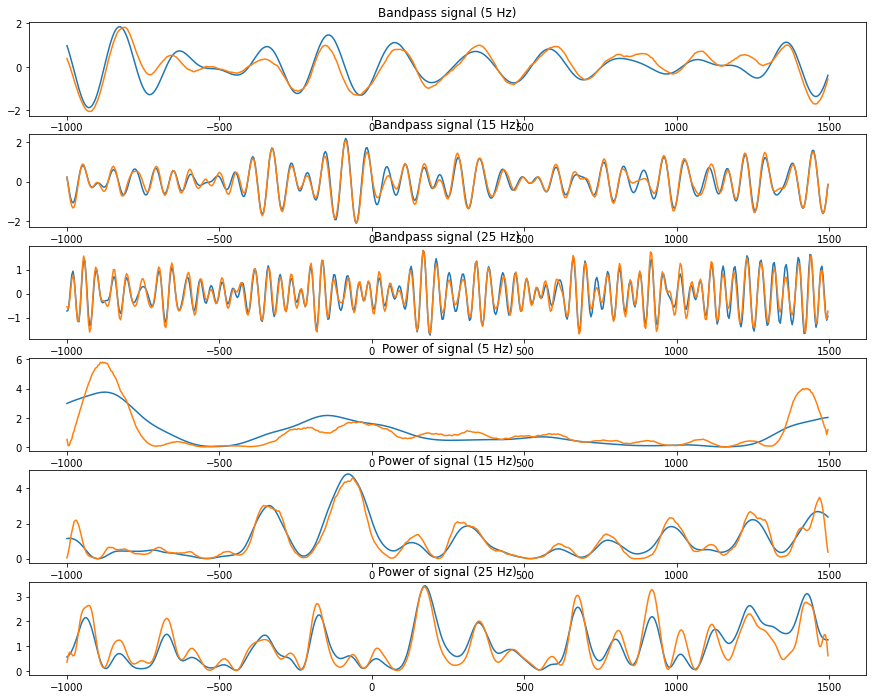

In [302]:
# This experiment for an individual trial

trial = data_eeg[0][:,0]

fig, axes = plt.subplots(6, 1, figsize=((15, 12)))

n = 6
n_taps = 71

for i, f in enumerate([5, 15, 25]):
    f_data = wave_convolution(trial, f, fs, 6)
    
    ax = axes[i]
    ax.plot(times_eeg, np.real(f_data))
    ax.set_title(f'Bandpass signal ({f} Hz)')
    
    ax = axes[i+3]
    ax.plot(times_eeg, (np.real(f_data)**2 + np.imag(f_data)**2))
    ax.set_title(f'Power of signal ({f} Hz)')

    
for i, band in enumerate(([0, 3, 4, 6, 7, fs/2],
                           [0, 9, 12, 18, 21, fs/2],
                           [0, 15, 20, 30, 35, fs/2])):
    an_f_data = filter_hilbert(trial, band, 
                            [0, 0, 1, 1, 0, 0],
                            fs, n_taps)
    
    ax = axes[i]
    ax.plot(times_eeg, np.real(an_f_data))

    ax = axes[i+3]
    ax.plot(times_eeg, (np.real(an_f_data)**2 + np.imag(an_f_data)**2))

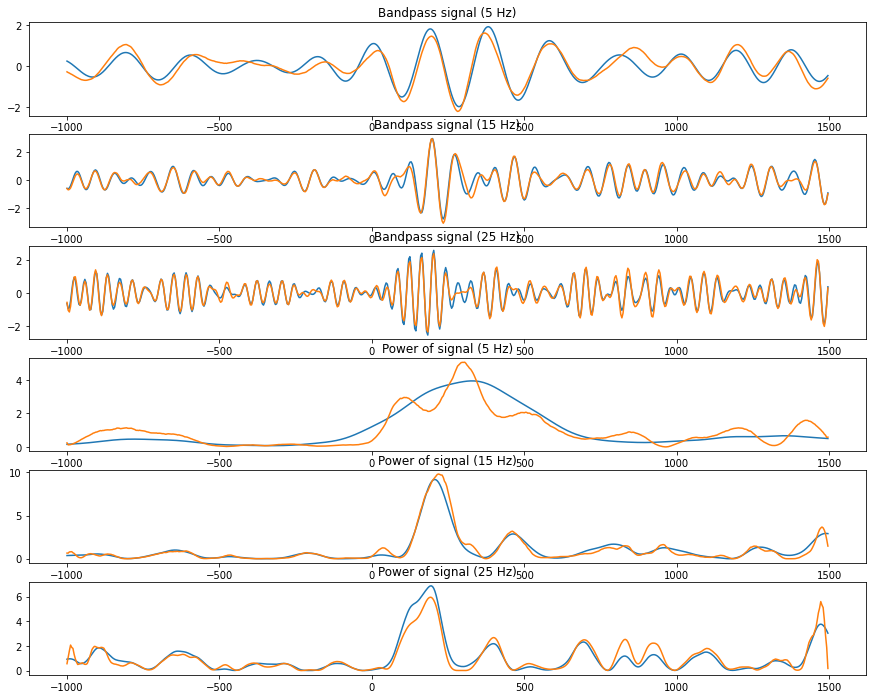

In [304]:
# This experiment for the averaged over trials eeg signal

data = np.mean(data_eeg[0], axis=-1)

fig, axes = plt.subplots(6, 1, figsize=((15, 12)))

n = 6
n_taps = 71

for i, f in enumerate([5, 15, 25]):
    f_data = wave_convolution(data, f, fs, 6)
    
    ax = axes[i]
    ax.plot(times_eeg, np.real(f_data))
    ax.set_title(f'Bandpass signal ({f} Hz)')
    
    ax = axes[i+3]
    ax.plot(times_eeg, (np.real(f_data)**2 + np.imag(f_data)**2))
    ax.set_title(f'Power of signal ({f} Hz)')

    
for i, band in enumerate(([0, 3, 4, 6, 7, fs/2],
                           [0, 9, 12, 18, 21, fs/2],
                           [0, 15, 20, 30, 35, fs/2])):
    an_f_data = filter_hilbert(data, band, 
                            [0, 0, 1, 1, 0, 0],
                            fs, n_taps)
    
    ax = axes[i]
    ax.plot(times_eeg, np.real(an_f_data))

    ax = axes[i+3]
    ax.plot(times_eeg, (np.real(an_f_data)**2 + np.imag(an_f_data)**2))

#### As we see the filter-hilbert method works a little bit worse on the lower frequencies. If the number of taps are made bigger then the situation becomes better. But anyway on the power spectrum we see a little distortion

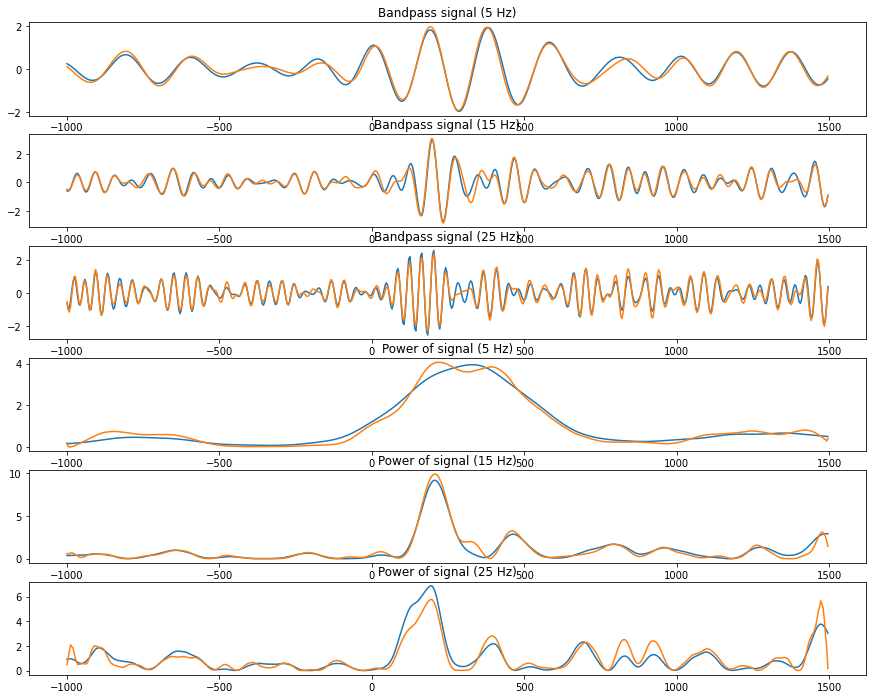

In [305]:
# This experiment for the averaged over trials eeg signal
# Increased the number of taps

data = np.mean(data_eeg[0], axis=-1)

fig, axes = plt.subplots(6, 1, figsize=((15, 12)))

n = 6
n_taps = 131

for i, f in enumerate([5, 15, 25]):
    f_data = wave_convolution(data, f, fs, n)
    
    ax = axes[i]
    ax.plot(times_eeg, np.real(f_data))
    ax.set_title(f'Bandpass signal ({f} Hz)')
    
    ax = axes[i+3]
    ax.plot(times_eeg, (np.real(f_data)**2 + np.imag(f_data)**2))
    ax.set_title(f'Power of signal ({f} Hz)')

    
for i, band in enumerate(([0, 3, 4, 6, 7, fs/2],
                           [0, 9, 12, 18, 21, fs/2],
                           [0, 15, 20, 30, 35, fs/2])):
    an_f_data = filter_hilbert(data, band, 
                            [0, 0, 1, 1, 0, 0],
                            fs, n_taps)
    
    ax = axes[i]
    ax.plot(times_eeg, np.real(an_f_data))

    ax = axes[i+3]
    ax.plot(times_eeg, (np.real(an_f_data)**2 + np.imag(an_f_data)**2))

#### Below I try to make methods look different by decreasing the number of taps and increasing the filtering window of the FIR

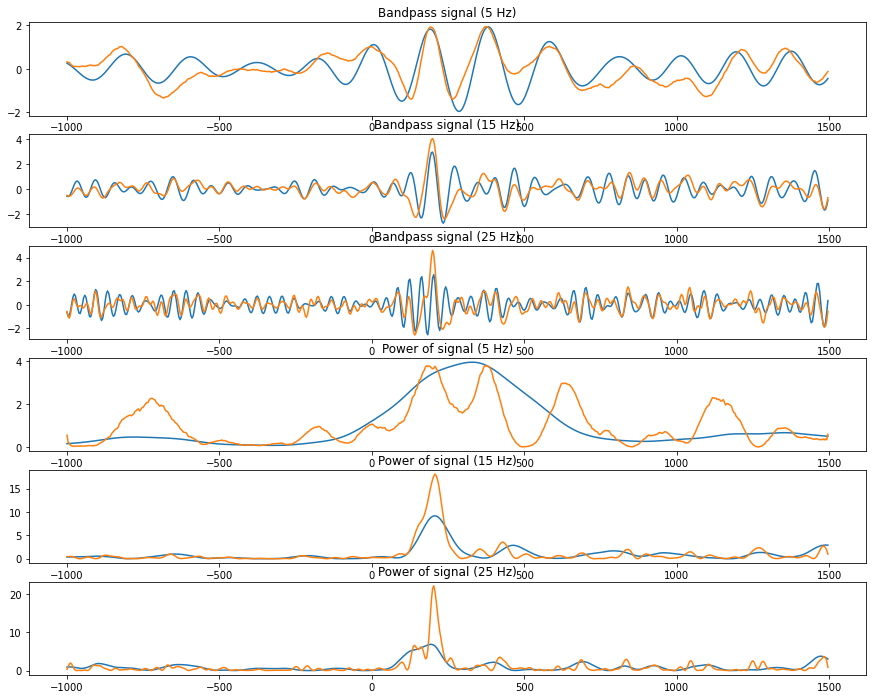

In [307]:
# This experiment for the averaged over trials eeg signal

data = np.mean(data_eeg[0], axis=-1)

fig, axes = plt.subplots(6, 1, figsize=((15, 12)))

n = 6
n_taps = 41

for i, f in enumerate([5, 15, 25]):
    f_data = wave_convolution(data, f, fs, 6)
    
    ax = axes[i]
    ax.plot(times_eeg, np.real(f_data))
    ax.set_title(f'Bandpass signal ({f} Hz)')
    
    ax = axes[i+3]
    ax.plot(times_eeg, (np.real(f_data)**2 + np.imag(f_data)**2))
    ax.set_title(f'Power of signal ({f} Hz)')

    
for i, band in enumerate(([0, 1, 2, 8, 9, fs/2],
                           [0, 5, 8, 22, 25, fs/2],
                           [0, 5, 10, 40, 45, fs/2])):
    an_f_data = filter_hilbert(data, band, 
                            [0, 0, 1, 1, 0, 0],
                            fs, n_taps)
    
    ax = axes[i]
    ax.plot(times_eeg, np.real(an_f_data))

    ax = axes[i+3]
    ax.plot(times_eeg, (np.real(an_f_data)**2 + np.imag(an_f_data)**2))

## Short FFT with or without multitapers

1. Pick one electrode and compute a time-frequency map of power
using both the multitaper method and the short-time FFT. Store all of
the power values for all of the trials.
2. Next, compute a time-frequency map of signal-to-noise ratio. The
signal-to-noise ratio of power is discussed more in chapter 18, but it can
be estimated as the average power at each time-frequency point across
trials, divided by the standard deviation of power at each timefrequency
point across trials.
3. Make time-frequency plots of power and signal-to-noise ratio from
the two methods. Make another plot in which you subtract the signal-tonoise
plots between the two methods. Are there any noticeable
differences between the signal-to-noise results when the multitaper
method versus the short-time FFT is used?
4. Select two frequencies, one relatively low and one relatively high
(e.g., 8 Hz and 60 Hz), and compare the power time series and signalto-
noise time series in these frequency bands from the two methods in a
separate figure, using line plots. Comment on the differences if there are
any.

#### In this section, I analyzed the differences between a short FFT using a single taper (Hann window) and a multitaper approach

In [129]:
# I use channel P7 in the analysis 
channel2plot = 'P7'
chan2useidx = eeg['chanlocs'][0]['labels']==channel2plot
data = data_eeg[chan2useidx]

st = -700 # start of the analysed segment (in ms)
end = 1200 # end of the analysed segment (in ms)
timewin = 400 # time window length (in ms)
step = 50 # step size between analyzed time points (in ms)
stid = np.argmin(np.abs(times_eeg - st)) # time index of the start time
endid = np.argmin(np.abs(times_eeg - end)) # time index of the end time

pinwin = round(timewin / (1000 / fs)) # number of time points in the window
pinstep = round(step / (1000 / fs)) # number of time points in the step

hann_win = 0.5 * (1 - np.cos(2 * np.pi * np.arange(pinwin) / (pinwin - 1))) # Hann Window

freqs = np.linspace(0, fs / 2, math.floor(pinwin / 2) + 1) # sequences of the output frequencies

baseline_range = [-500, -200] # the normalizaion interval (in ms)

In [175]:
# return time in the middle of window 
def get_mid_time(times, lowbound, upbound):

    if (upbound - lowbound) % 2:
        return int(times_eeg[int(lowbound + (upbound - lowbound) / 2)])
    else:
        return int(times_eeg[lowbound] + (times_eeg[upbound] - times_eeg[lowbound]) / 2)

# return the Fourier Transform of all tapered segments 
# between 'start' and 'end' with step
def tf_with_tapers(data, tapers, times, start, end, window, step):
    tf = dict()

    lowbound = start
    upbound = start + window

    while upbound < end:
        mid_point = get_mid_time(times, lowbound, upbound)

        tf[mid_point] = np.zeros((int(np.floor(pinwin / 2) + 1), data.shape[-1]))
        
        andata = np.squeeze(data[:,lowbound:upbound, :])

        # taperdata = andata * hann_win
        for taper in tapers:
            taperdata = andata * taper[:, None]

            # fdata = np.fft.fft(taperdata) / pinwin
            fdata = np.fft.fft(taperdata, axis=0)[0: int(np.floor(pinwin / 2) + 1), :] / pinwin

            # tf[get_mid_time(times_eeg, lowbound, upbound)] = np.abs(psd[0: int(np.floor(pinwin / 2) + 1)])**2
            power = fdata * np.conj(fdata)

            tf[mid_point] = tf[mid_point] + power 
        
        tf[mid_point] /= len(tapers)
        
        lowbound += pinstep
        upbound += pinstep
        
    return tf

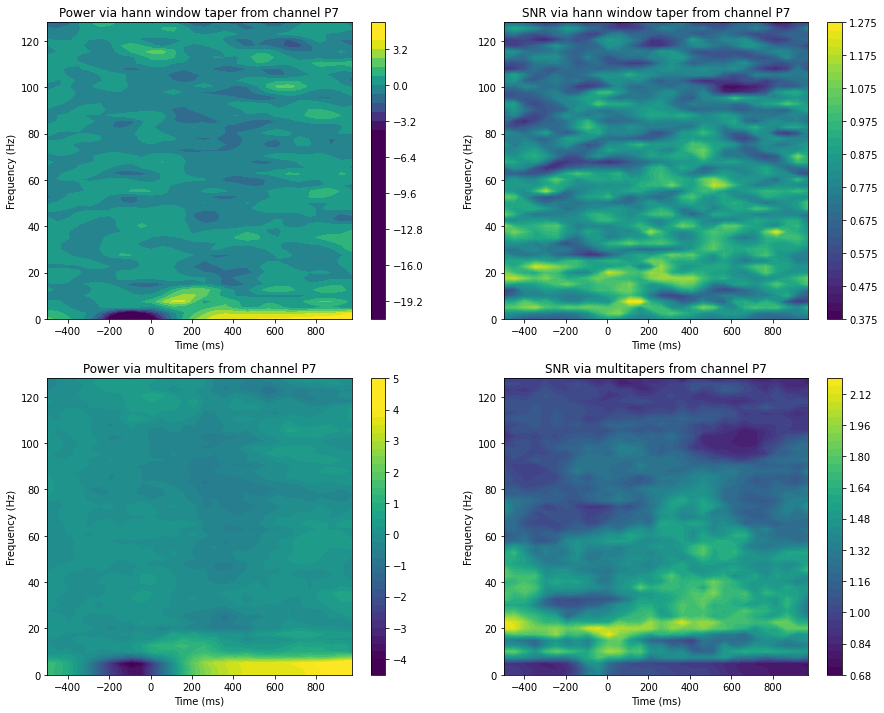

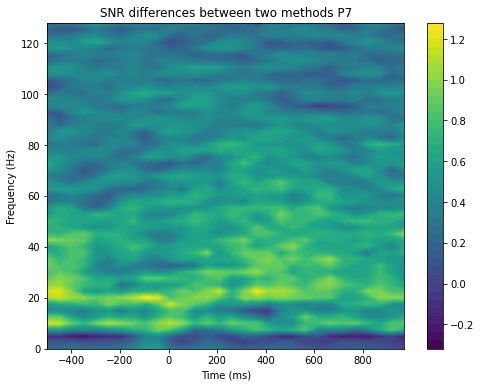

In [176]:
fig, axes = plt.subplots(2, 2, figsize=((15, 12)))


# this part plots time frequency map for tapered short FFT
tap_tf = tf_with_tapers(data, [hann_win], times_eeg, stid, endid, pinwin, pinstep)
tap_time = np.array(list(tap_tf.keys()))
tap_power = np.array([x for x in tap_tf.values()])


ax = axes[0, 0]

av_tap_power = np.mean(tap_power, axis=-1).T
# apply decibel conversion as the normalization here
baseidx = [np.argmin(np.abs(tap_time - br)) for br in baseline_range]
av_tap_power = 10 * np.log10(av_tap_power / np.mean(av_tap_power[:, baseidx[0]:baseidx[1]+1], axis=1)[:, np.newaxis])

tap_map = ax.contourf(tap_time, freqs, av_tap_power, 40, cmap='viridis')
plt.colorbar(tap_map)
tap_map.set_clim(-4, 4)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title(f'Power via hann window taper from channel {channel2plot}')

# this visualizes time frequency map for this data but it's SNR 
ax = axes[0, 1]

taper_snr = (np.mean(tap_power, axis=-1)/np.var(tap_power, axis=-1)**(1/2)).T

tap_snr_map = ax.contourf(tap_time, freqs, taper_snr, 40, cmap='viridis')
plt.colorbar(tap_snr_map)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title(f'SNR via hann window taper from channel {channel2plot}')


multitap_tf = tf_with_tapers(data, tapers[:-1, :], times_eeg, stid, endid, pinwin, pinstep)
multitap_time = np.array(list(multitap_tf.keys()))
multitap_power = np.array([x for x in multitap_tf.values()])

# the second part does the same but for multitapers 
ax = axes[1, 0]

av_multitap_power = np.mean(multitap_power, axis=-1).T
baseidx = [np.argmin(np.abs(multitap_time - br)) for br in baseline_range]
av_multitap_power = 10 * np.log10(av_multitap_power / np.mean(av_multitap_power[:, baseidx[0]:baseidx[1]+1], axis=1)[:, np.newaxis])

multitap_map = ax.contourf(multitap_time, freqs, av_multitap_power, 40, cmap='viridis')
plt.colorbar(multitap_map)
multitap_map.set_clim(-4, 4)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title(f'Power via multitapers from channel {channel2plot}')

ax = axes[1, 1]

multitaper_snr = (np.mean(multitap_power, axis=-1)/np.var(multitap_power, axis=-1)**(1/2)).T

multitap_snr_map = ax.contourf(multitap_time, freqs, multitaper_snr, 40, cmap='viridis')
plt.colorbar(multitap_snr_map)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title(f'SNR via multitapers from channel {channel2plot}')



plt.figure(figsize=(8, 6))
diff_map = plt.contourf(multitap_time, freqs, multitaper_snr-taper_snr, 40,  cmap='viridis')
plt.colorbar(diff_map)
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title(f'SNR differences between two methods {channel2plot}')
plt.show()

#### As we see multitapers give more smooth result due to spectral smoothing, but more important it has higher SNR especially at high frequencies.

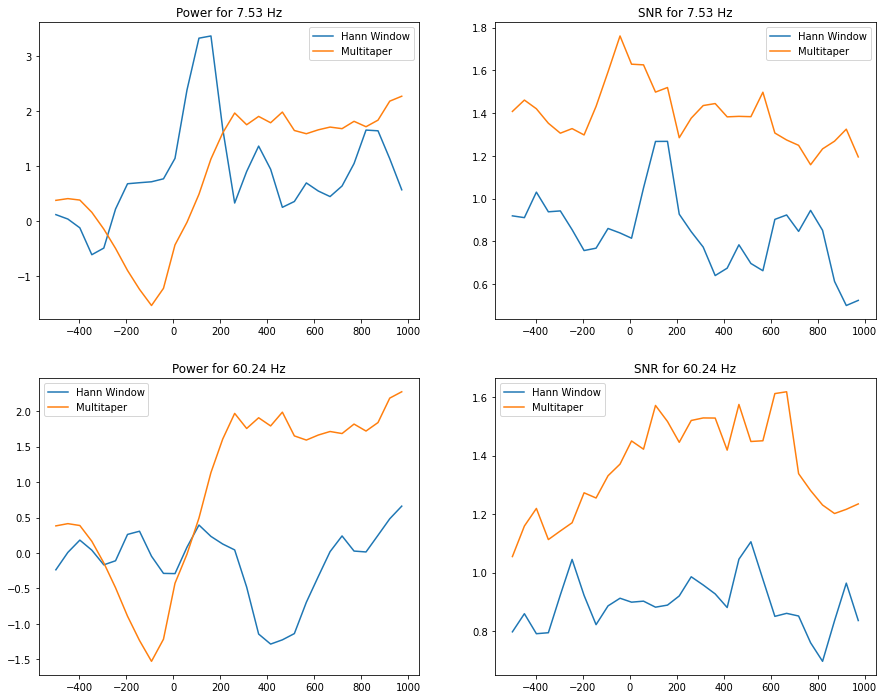

In [177]:
# Visualise plots for low and high frequencies
fig, axes = plt.subplots(2, 2, figsize=((15, 12)))


frid = np.argmin(np.abs(freqs - 8))
fr = freqs[frid]

ax = axes[0, 0]

ax.set_title(f'Power for {fr:.2f} Hz')
ax.plot(time, av_tap_power[frid,:], label='Hann Window')
ax.plot(time, av_multitap_power[frid,:], label='Multitaper')
ax.legend()

ax = axes[0, 1]
ax.set_title(f'SNR for {fr:.2f} Hz')
ax.plot(time, taper_snr[frid,:], label='Hann Window')
ax.plot(time, multitaper_snr[frid,:], label='Multitaper')
ax.legend()

frid = np.argmin(np.abs(freqs - 60))
fr = freqs[frid]

ax = axes[1, 0]

ax.set_title(f'Power for {fr:.2f} Hz')
ax.plot(time, av_tap_power[frid,:], label='Hann Window')
ax.plot(time, av_multitap_power[3,:], label='Multitaper')
ax.legend()

ax = axes[1, 1]
ax.set_title(f'SNR for {fr:.2f} Hz')
ax.plot(time, taper_snr[frid,:], label='Hann Window')
ax.plot(time, multitaper_snr[frid,:], label='Multitaper')
ax.legend()

### We observe the same results as below, but here we also see that the multitaper method estimates higher power than the single-taper method. This may occur because multitapers produce less biased estimates.

## ITPC

#### Exercise: Pick three electrodes. Compute time-frequency plots of ITPC and decibel-corrected power for these electrodes, using either complex Morlet wavelet convolution or the filter-Hilbert method. Plot the results side by side for each electrode (power and ITPC in subplots; one figure for each electrode).

In [3]:
def morlet(times, f, n):
    s = n / (2 * np.pi * f)
    # A = 1 / np.sqrt(s * np.sqrt(np.pi))
    A = 1
    wave = np.exp(2 * 1j * np.pi * f * times)
    gaus = np.exp(-times**2 / (2 * s**2))
  
    return A * wave * gaus

def wave_convolution(data, f, fs, n):
    w_times = np.arange(-1, 1+1/fs, 1/fs)
    wavelet = morlet(w_times, f, n)  
    
    n_data = len(data)
    n_wave = len(w_times)
    
    # convolution
    conv_data = np.fft.fft(data, n_data + n_wave - 1, axis=0)
    conv_wave = np.fft.fft(wavelet, n_data + n_wave - 1)
    f_data = np.fft.ifft(conv_data * conv_wave[:, None], axis=0)
    
    f_data = f_data[int(np.floor(n_wave / 2)):-int(np.ceil(n_wave / 2) - 1), :]
    
    return f_data

/var/folders/w8/ttg_lnyx4dj8lfctwhbhd7xw0000gn/T/ipykernel_5553/903410715.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  power[i:, ] = np.mean(f_data*np.conjugate(f_data), axis=1)


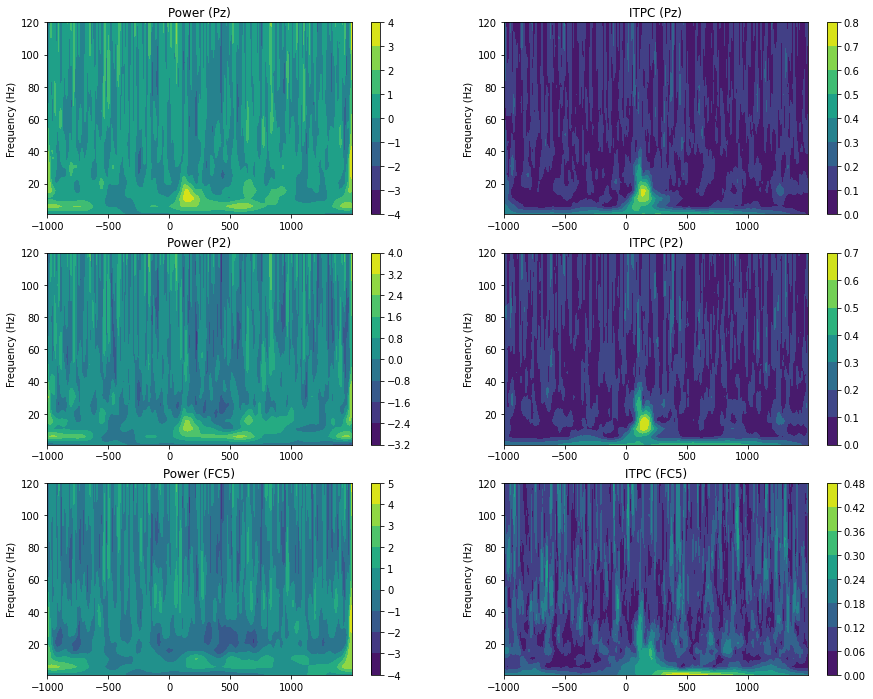

In [38]:
fig, axes = plt.subplots(3, 2, figsize=((15, 12)))

n = 4
baseline_range = [-500, -200]
baseidx = [np.argmin(np.abs(times_eeg - br)) for br in baseline_range]

freqs = np.linspace(1, 120, 25)
for j, chan2plot in enumerate(['Pz', 'P2', 'FC5']):
    data = np.squeeze(eeg['data'][eeg['chanlocs'][0]['labels']==chan2plot, :, :])

    itps = np.zeros((len(freqs), data.shape[0]))
    power = np.zeros((len(freqs), data.shape[0]))

    for i, f in enumerate(freqs):
        f_data = wave_convolution(data, f, fs, n)

        power[i:, ] = np.mean(f_data*np.conjugate(f_data), axis=1) 

        itps[i:, ] = np.abs(np.mean(np.exp(1j*np.angle(f_data)), axis=1))


    norm_power = 10 * np.log10(power[:, ] / np.mean(power[:, baseidx[0]:baseidx[1]+1], axis=1)[:, np.newaxis])

    ax = axes[j, 0]
    power_map = ax.contourf(times_eeg, freqs, norm_power)
    plt.colorbar(power_map)
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(f'Power ({chan2plot})')

    ax = axes[j, 1]
    itpc_map = ax.contourf(times_eeg, freqs, itps)
    plt.colorbar(itpc_map)
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(f'ITPC ({chan2plot})')

#### Question: Are the patterns of results from ITPC and power generally similar or generally different? Do the results look more similar at some electrodes and less similar at other electrodes?

####  Answer: Yes, we observe similarity for the Pz and P2 electrodes, indicating some form of synchronization. However, this pattern is not evident for FC5.



####  For each of these three electrodes, compute wITPCz using reaction time as the trial-varying modulator. Perform this analysis across all time-frequency points to generate maps showing the relationship between phase and reaction time.

In [5]:
# Fetching response time for wITPCz
rts = np.zeros(eeg['trials'][0][0])

for ei in range(eeg['trials'][0][0]):
    # Find which event is time=0, and take the latency of the event thereafter.
    time0event = np.where(np.array(eeg['epoch'][0][ei]['eventlatency'][0]) == 0)[0][0]
    
    # Use try-except in case of no response
    try:
        rts[ei] = eeg['epoch'][0][ei]['eventlatency'][0][time0event + 1]
    except IndexError:
        rts[ei] = np.nan


/var/folders/w8/ttg_lnyx4dj8lfctwhbhd7xw0000gn/T/ipykernel_5553/1014635263.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rts[ei] = eeg['epoch'][0][ei]['eventlatency'][0][time0event + 1]


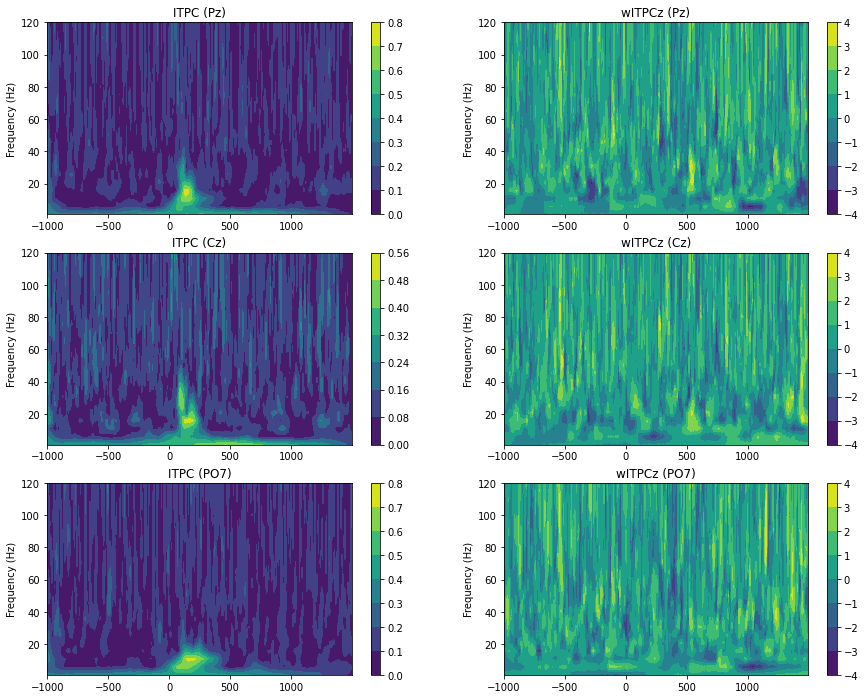

In [43]:

fig, axes = plt.subplots(3, 2, figsize=((15, 12)))
n = 4

witpc_z = np.zeros((len(freqs), data.shape[0]))
itps = np.zeros((len(freqs), data.shape[0]))

for chi, chan2plot in enumerate(['Pz', 'Cz', 'PO7']):
    data = np.squeeze(eeg['data'][eeg['chanlocs'][0]['labels']==chan2plot, :, :])

    witps = np.zeros((len(freqs), data.shape[0]))
    power = np.zeros((len(freqs), data.shape[0]))
    
     
    for fi, f in enumerate(freqs):
        
        f_data = wave_convolution(data, f, fs, n)
        itps[fi:, ] = np.abs(np.mean(np.exp(1j*np.angle(f_data)), axis=1))
        
        for ti, cut in enumerate(f_data):
            exp_phase = np.exp(1j*np.angle(cut))
        
            witps = np.abs(np.mean(rts*exp_phase))

            perm_witpc = np.zeros(200)
            for j in range(200):
                perm_witpc[j] = np.abs(np.mean(rts[np.random.permutation(n_trials_eeg)] * exp_phase))

            witpc_z[fi, ti] = (witps - np.mean(perm_witpc)) / np.std(perm_witpc)

    ax = axes[chi, 0]
    itpc_map = ax.contourf(times_eeg, freqs, itps)
    plt.colorbar(itpc_map)
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(f'ITPC ({chan2plot})')

    ax = axes[chi, 1]
    witpc_map = ax.contourf(times_eeg, freqs, witpc_z)
    plt.colorbar(witpc_map)
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(f'wITPCz ({chan2plot})')

####  Do the time-frequency maps of wITPCz look different from the time-frequency maps of ITPC? Do you see any striking patterns in the ITPCz results, and do the results differ across the different electrodes (don't worry about statistics, base your judgment on qualitative patterns)? How would you interpret the results if they were statistically significant?

####  Answer: In ITPS, we do not observe any significant activity in the [0–500] ms window around 10 Hz. This region may only be significant in ITPC due to the influence of response time.

####  I decided additionally to calculate pixel-based statistics

Text(0.5, 0, 'Time (ms)')

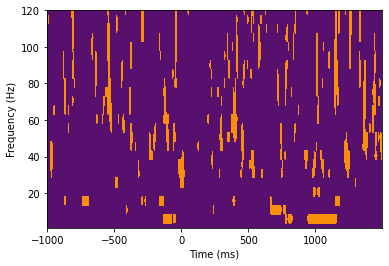

In [66]:
# highlight statistical significant part
low_thresh = np.percentile(witpc_z, 2.5)
high_thresh = np.percentile(witpc_z, 97.5)

mask = (witpc_z <= low_thresh) | (witpc_z >= high_thresh)

plt.contourf(times_eeg, freqs, mask, cmap='inferno')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)')

#### The analysis shows significant points scattered throughout the entire image. Since this method selects significant points regardless of clustering, I am inclined to believe there is no true statistical significance, as no distinct clusters are visible.

####  Cluster-based permutation testing is more robust but also more complex to implement. Therefore, I will reserve it for future practical work if it becomes necessary.